In [1]:
%cd /home/thucth/thucth/project/id_occlusion

/home/thucth/thucth/project/id_occlusion


In [2]:
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from tty import CFLAG
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
import matplotlib.pyplot as plt

from src import utils
from src.models.models import create_model, safe_model_name, resume_checkpoint, model_parameters
from src.metrics.losses import *
from src.optim import create_optimizer_v2, optimizer_kwargs
from src.scheduler import create_scheduler

torch.cuda.set_device(1)
_logger = logging.getLogger('train')


/home/thucth/.conda/envs/torch19/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load model

In [6]:
utils.setup_default_logging()

_logger.info('Training start...')
utils.random_seed(1101)

# create model
model = create_model(
    'efficientnet_b0',
    num_classes=1,
    in_chans=3,
    pretrained=False,
    checkpoint_path="/home/thucth/thucth/project/id_occlusion/outputs/efficientnet_b0/v6_more_out_in_224/model_best.pth.tar")
model.cuda()

model.eval()

Training start...
Training start...
Loaded state_dict from checkpoint '/home/thucth/thucth/project/id_occlusion/outputs/efficientnet_b0/v6_more_out_in_224/model_best.pth.tar'
Loaded state_dict from checkpoint '/home/thucth/thucth/project/id_occlusion/outputs/efficientnet_b0/v6_more_out_in_224/model_best.pth.tar'


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

## validation on batch

In [15]:

from src import utils
from src.models.models import create_model, safe_model_name, resume_checkpoint, model_parameters
from src.datasets.load_data import *
from src.datasets import preprocess
from src.metrics.losses import *
from src.optim import create_optimizer_v2, optimizer_kwargs
from src.scheduler import create_scheduler
from src.utils import get_parser

from src.datasets.load_data import *
from src.datasets import preprocess
# create the train and eval datasets
input_size = (112,112,3)
mean=None
std=None
train_ds_path = "./resources/data_occlusion_train_new.csv"
val_ds_path = "./resources/data_occlusion_val.csv"
batch_size=1
validation_batch_size=1
workers=16

tg_tf = preprocess.create_target_tf()
train_tf = preprocess.create_train_tf(input_size=input_size[:-1], means=mean, stds=std)
val_tf = preprocess.create_val_tf(input_size=input_size[:-1], means=mean, stds=std)

train_ds = DatasetFromCsv(annotations_file=train_ds_path,
                          transform=train_tf,
                          target_transform=tg_tf)

val_ds = DatasetFromCsv(annotations_file=val_ds_path,
                        transform=val_tf,
                        target_transform=tg_tf)

train_loader = create_dataloader(train_ds,
                                 batch_size=batch_size,
                                 workers=workers,
                                 shuffle=True)
val_loader = create_dataloader(val_ds,
                               batch_size=validation_batch_size,
                               workers=workers,
                               shuffle=True)


In [ ]:
plt.figure(figsize=(10,10))
i=0
for img, label in val_loader:
    plt.imshow(img[0].permute(1,2,0).numpy())
    output=model(img)
    plt.title(label="label: %s - pred: %s" %(label.item(), int(output.item())))
    plt.show()
    i+=1
    if i==10:break

## validation on images folder

In [7]:
from src import utils
from src.models.models import create_model, safe_model_name, resume_checkpoint, model_parameters
from src.datasets.load_data import *
from src.datasets import preprocess
from src.metrics.losses import *
from src.optim import create_optimizer_v2, optimizer_kwargs
from src.scheduler import create_scheduler
from src.utils import get_parser

from src.datasets.load_data import *
from src.datasets import preprocess
from glob import glob

# create the train and eval datasets
# input_size = (112, 112, 3)
input_size = (224, 224, 3)
mean = None
std = None
img_paths = glob(os.path.join("./resources/my_id","*.jpg"))
batch_size = 1
validation_batch_size = 1
workers = 16


/tmp/ipykernel_75600/2749180775.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.unsqueeze(torch.tensor(img), 0).cuda()


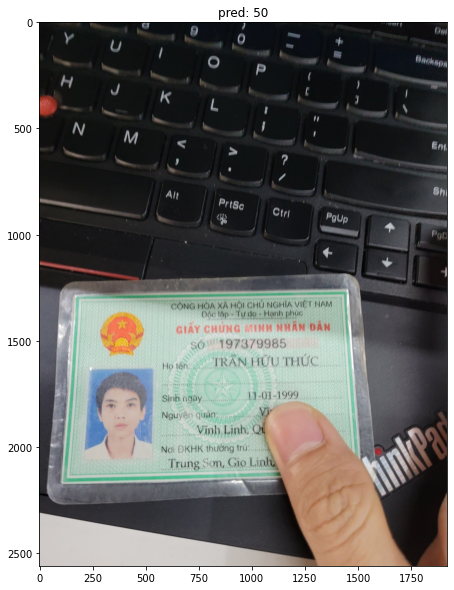

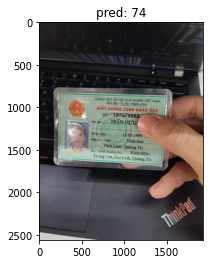

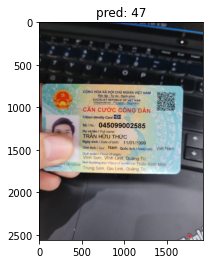

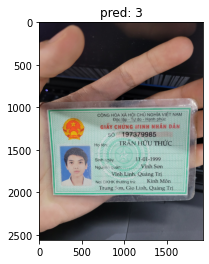

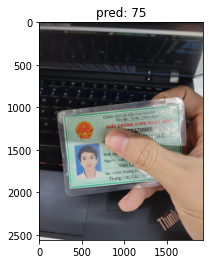

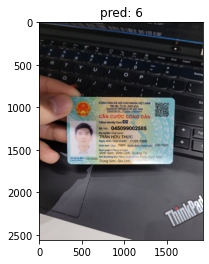

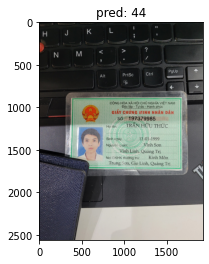

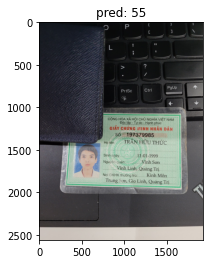

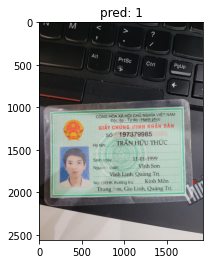

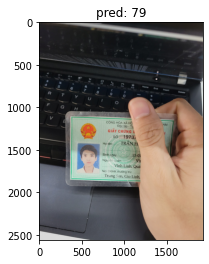

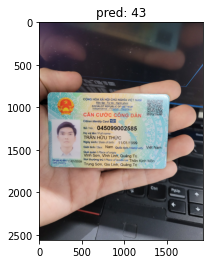

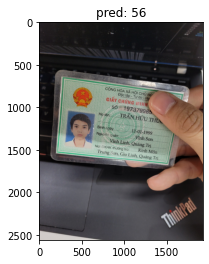

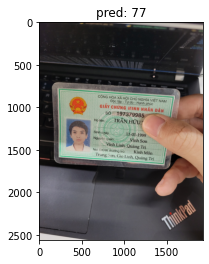

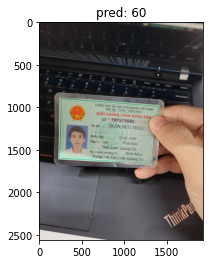

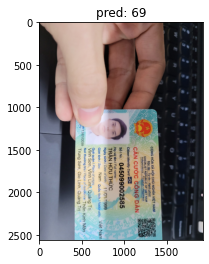

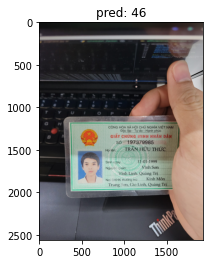

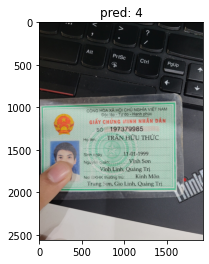

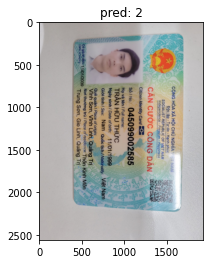

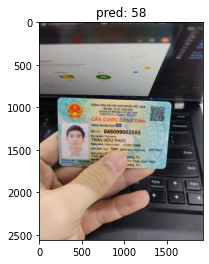

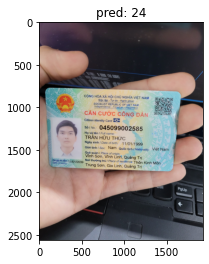

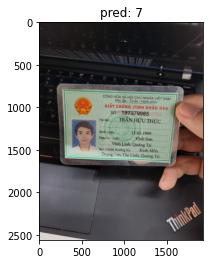

In [8]:
import cv2

plt.figure(figsize=(10, 10))

tg_tf = preprocess.create_target_tf()
val_tf = preprocess.create_val_tf(input_size=input_size[:-1], means=mean, stds=std)
    
for img_path in img_paths:
    img = cv2.imread(img_path)[:,:,::-1]
    plt.imshow(img)

    img = val_tf(img)
    input = torch.unsqueeze(torch.tensor(img), 0).cuda()
    output = model(input)
    plt.title(label="pred: %s" % (int(output.item())))
    plt.show()


## Calibration